In [2]:
from modules import *

In [3]:
#dataset load
len_dataset=79855
load_profile('Elena')
qb = QueryBuilder()
qb.append(orm.StructureData)

In [4]:
select=100
qb_red=random.sample(qb.all(), select)
frames_ase=[]
for [structure_data] in qb_red:
    frame=structure_data.get_ase()
    frame.wrap()
    frames_ase.append(frame)
# array1 = np.random.randint(0,len_dataset-1, size=len_dataset)
# len(array1)
# masked = (qb.all()[array1] > int(len_dataset-(len_dataset-select)))
# # print(type(masked))


In [5]:
def frames(x):
    for [structure_data] in x:
        frame=structure_data.get_ase()
        frame.wrap(eps=1e-11)
        yield frame
def atomic_numbers(x):
    for [structure_data] in x:
        frame=structure_data.get_ase()
        mass=frame.get_atomic_numbers()
        yield mass
def natoms(x):
    for [structure_data] in x:
        natom = len(structure_data.get_site_kindnames())
        yield natom
def volumes(x):
    for [structure_data] in x:
        frame=structure_data.get_ase()
        vol=frame.get_volume()
        yield vol
 

In [6]:
# Compute SOAPs (from librascal tutorial)
# soap = SOAP(soap_type='PowerSpectrum',
#            interaction_cutoff=3.5,
#            max_radial=6,
#            max_angular=6,
#            gaussian_sigma_type='Constant',
#            gaussian_sigma_constant=0.4,
#            cutoff_smooth_width=0.5)

soap = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=6,
           max_angular=6,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.4,
           cutoff_smooth_width=0.5)

soap_rep = soap.transform(frames(qb_red))


In [7]:
X_raw = soap_rep.get_features(soap)

num_features = X_raw.shape[1]

"""Checking how many rows with all 0.0 entries are there"""
p = np.where(X_raw != 0)
type(p)
X_raw_new = X_raw[min(p[0]) : max(p[0]) + 1, min(p[1]) : max(p[1]) + 1]
print('There are '+str(X_raw.shape[0]-X_raw_new.shape[0])+' rows with all zero entries that are slowing down the calculation and do not contribute to SOAP vector')

There are 0 rows with all zero entries that are slowing down the calculation and do not contribute to SOAP vector


In [8]:
"""First methos with conda package at https://pypi.org/project/cur/"""
r = 100
C_cur, U, R = cur_decomposition (X_raw, r)
X_raw.shape, C_cur.shape, U.shape, R.shape

# """Second method from definitions in cell above"""

# plot_cur_error(X_raw, upto=10)


((3512, 96768), (3512, 100), (100, 100), (100, 96768))

In [9]:
# FPS the components
print(f"Each SOAP vector contains {num_features} components.\
       \nWe use furthest point sampling to generate a subsample of our SOAP vectors.")

n_FPS=100
col_idxs, col_dist = FPS(X_raw.T, n_FPS)
X_FPS = X_raw[:, col_idxs]
X_FPS.shape

Each SOAP vector contains 96768 components.       
We use furthest point sampling to generate a subsample of our SOAP vectors.


(3512, 100)

In [10]:
# properties=['masses', 'masses']
# Y = np.vstack([np.concatenate([frame.arrays[property] for frame in frames_ase]) for property in properties]).T
l=np.concatenate(frames_ase)
len(l)
Y=np.zeros((len(l), 1))

natoms_list=[]
start=0
for frame in frames_ase:
    natoms=(len(frame))
#     Y[start:int(start+natoms), 0] = int(natoms)
    if natoms%4==0:
        Y[start:int(start+natoms)] = int(2)
    else:
        Y[start:int(start+natoms)] = int(1)
    start=start+natoms
Y.shape


(3512, 1)

In [11]:
# Splits in train and test sets
X1=np.copy(X_FPS)
X2=np.copy(C_cur)

n_train = int(len(Y)/2)
n_test = len(Y)-n_train
r_train = np.asarray(range(len(Y)))
np.random.shuffle(r_train)
i_test = list(sorted(r_train[n_train:]))
i_train = list(sorted(r_train[:n_train]))

X1_train = X1[i_train]
X2_train = X2[i_train]
Y_train = Y[i_train]
X1_test = X1[i_test]
X2_test = X2[i_test]
Y_test = Y[i_test]

print(f'Shape of testing FPS data is: {X1_train.shape}, ||X|| = {np.linalg.norm(X1_train)}.') 
print(f'Shape of testing CUR data is: {X2_train.shape}, ||X|| = {np.linalg.norm(X2_train)}.') 


Shape of testing FPS data is: (1756, 100), ||X|| = 29.43657855103155.
Shape of testing CUR data is: (1756, 100), ||X|| = 41.83684329593049.


In [12]:
X1_center = X1_train.mean(axis=0)
X2_center = X2_train.mean(axis=0)
# Y_center = Y_train.mean(axis=0)

# Center total dataset
X1 = center_matrix(X1, center=X1_center)
X2 = center_matrix(X2, center=X2_center)
# Y = center_matrix(Y, center=Y_center)

# Center training data
X1_train = center_matrix(X1_train, center=X1_center)
X2_train = center_matrix(X2_train, center=X2_center)
# Y_train = center_matrix(Y_train, center=Y_center)

# Center testing data
X1_test = center_matrix(X1_test, center=X1_center)
X2_test = center_matrix(X2_test, center=X2_center)
# Y_test = center_matrix(Y_test, center=Y_center)

# Calculate the scale of the training data
X1_scale = np.linalg.norm(X1_train) / np.sqrt(n_train)
X2_scale = np.linalg.norm(X2_train) / np.sqrt(n_train)
# Y_scale = np.linalg.norm(Y_train) / np.sqrt(n_train)

# Scale the total dataset
X1 = normalize_matrix(X1, scale=X1_scale)
X2 = normalize_matrix(X2, scale=X2_scale)
# Y = normalize_matrix(Y, scale=Y_scale)

# Scale the training data
X1_train = normalize_matrix(X1_train, scale=X1_scale)
X2_train = normalize_matrix(X2_train, scale=X2_scale)
# Y_train = normalize_matrix(Y_train, scale=Y_scale)

# Scale the testing data
X1_test = normalize_matrix(X1_test, scale=X1_scale)
X2_test = normalize_matrix(X2_test, scale=X2_scale)
# Y_test = normalize_matrix(Y_test, scale=Y_scale)

In [13]:
C1 = X1_train.T @ X1_train
C2 = X2_train.T @ X2_train


v_C1, U_C1 = np.linalg.eigh(C1)
v_C2, U_C2 = np.linalg.eigh(C2)


# U_C/v_C are already sorted, but in *increasing* order, so reverse them
U_C1= np.flip(U_C1, axis=1)
v_C1= np.flip(v_C1, axis=0)

U_C2= np.flip(U_C2, axis=1)
v_C2= np.flip(v_C2, axis=0)

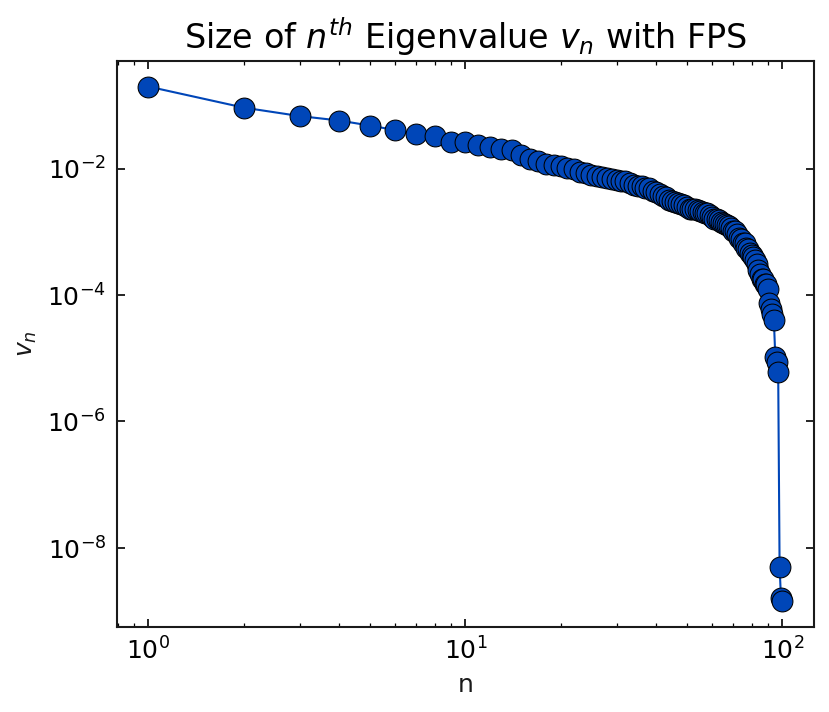

Text(0, 0.5, '$v_n$')

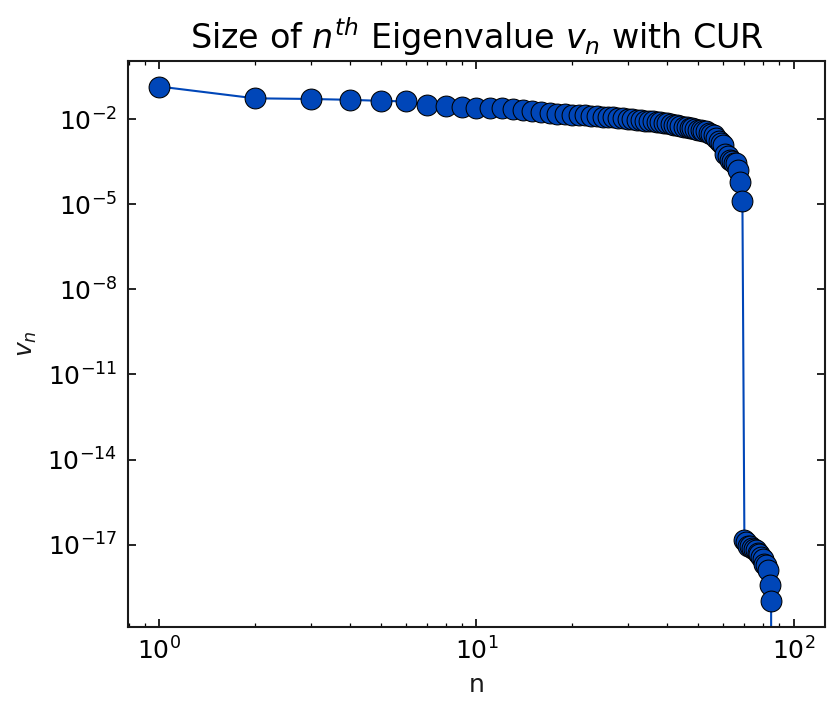

In [14]:
plt.loglog(np.asarray(range(len(v_C1))) + 1, v_C1 / n_train, marker="o")
plt.title(r"Size of $n^{th}$ Eigenvalue $v_n$ with FPS")
plt.xlabel("n")
plt.ylabel(r"$v_n$")
plt.show()
plt.close()
plt.loglog(np.asarray(range(len(v_C2))) + 1, v_C2 / n_train, marker="o")
plt.title(r"Size of $n^{th}$ Eigenvalue $v_n$ with CUR")
plt.xlabel("n")
plt.ylabel(r"$v_n$")

[[ 2.]
 [ 2.]
 [ 2.]
 ..., 
 [ 1.]
 [ 1.]
 [ 1.]]
(100, 100) (1756, 100) (1756, 100) (100, 100) (1756, 100) (1756, 100) (1756, 1)


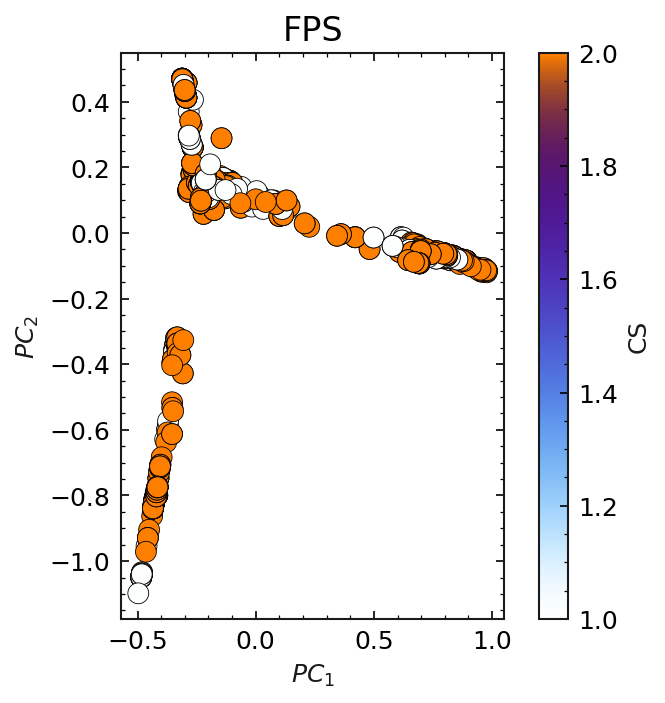

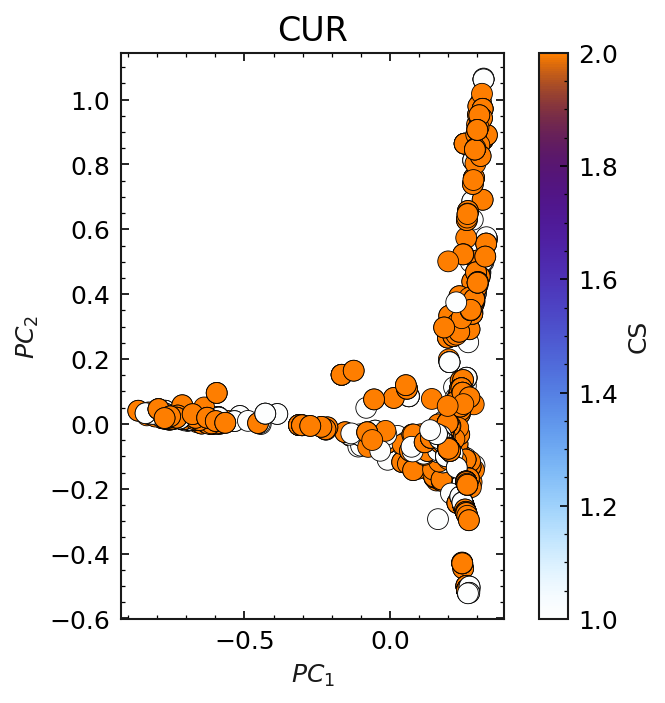

In [15]:
n_PC=100
PXT1 = U_C1[:, :n_PC]
PTX1 = PXT1.T

PXT2 = U_C2[:, :n_PC]
PTX2 = PXT2.T

print(Y_train)
T1 = X1_train @ PXT1
T2 = X2_train @ PXT2

print(PXT1.shape, X1_train.shape,  T1.shape,
      PXT2.shape, X2_train.shape,  T2.shape, Y_train.shape)

plot_projection(Y_train, T1, **cmaps, title='FPS')
plt.show()
plt.close()
plot_projection(Y_train, T2, **cmaps, title='CUR')

plt.savefig('PCA_tutorial_mixed_db.png', bbox_inches= 'tight', dpi=700)

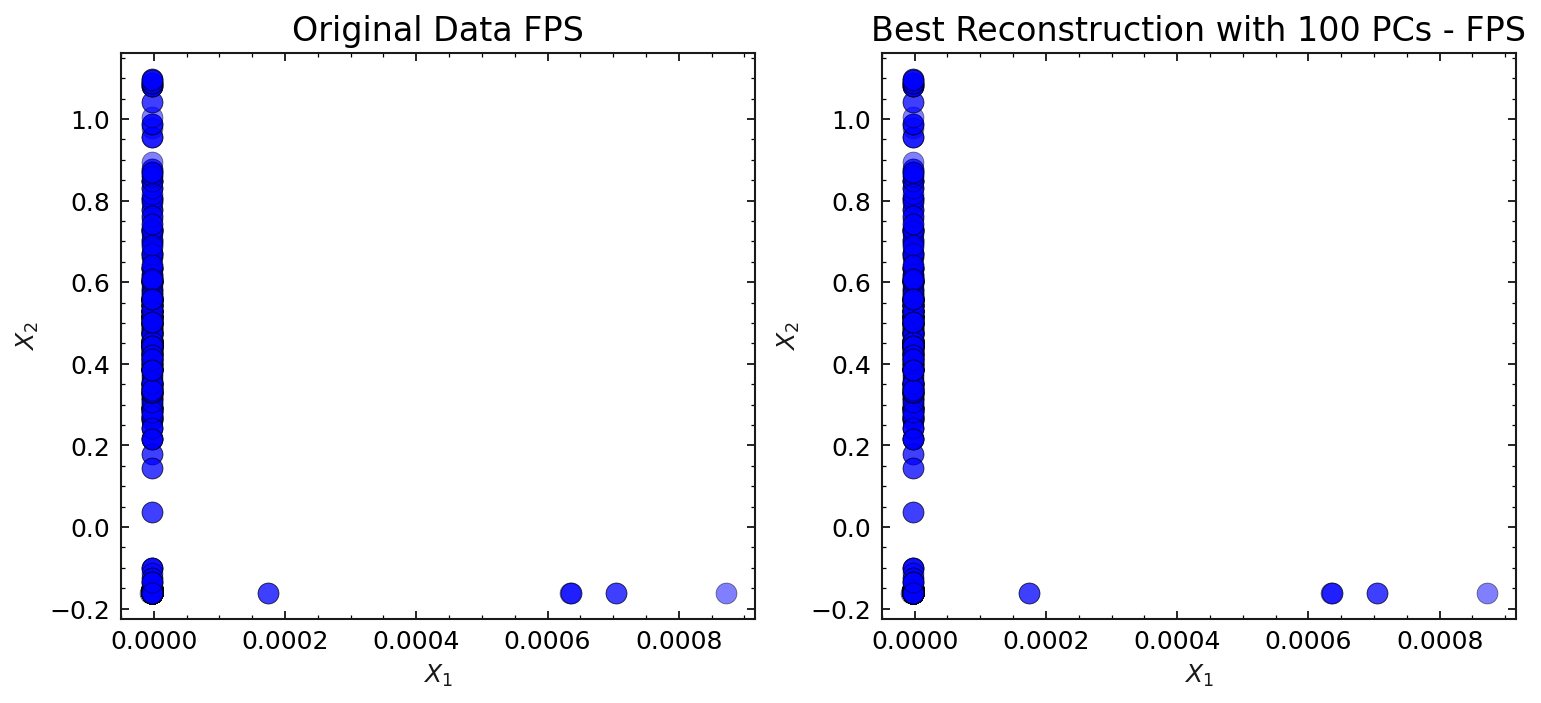

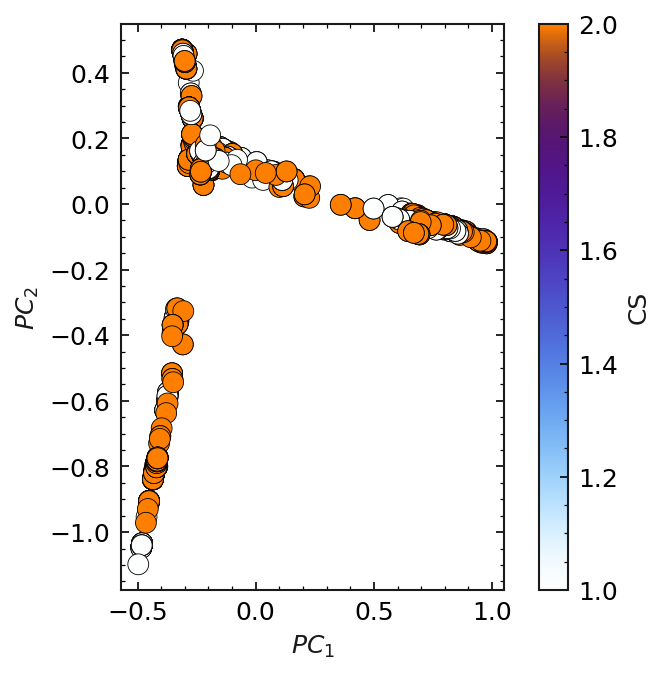

<AxesSubplot:xlabel='$PC_1$', ylabel='$PC_2$'>

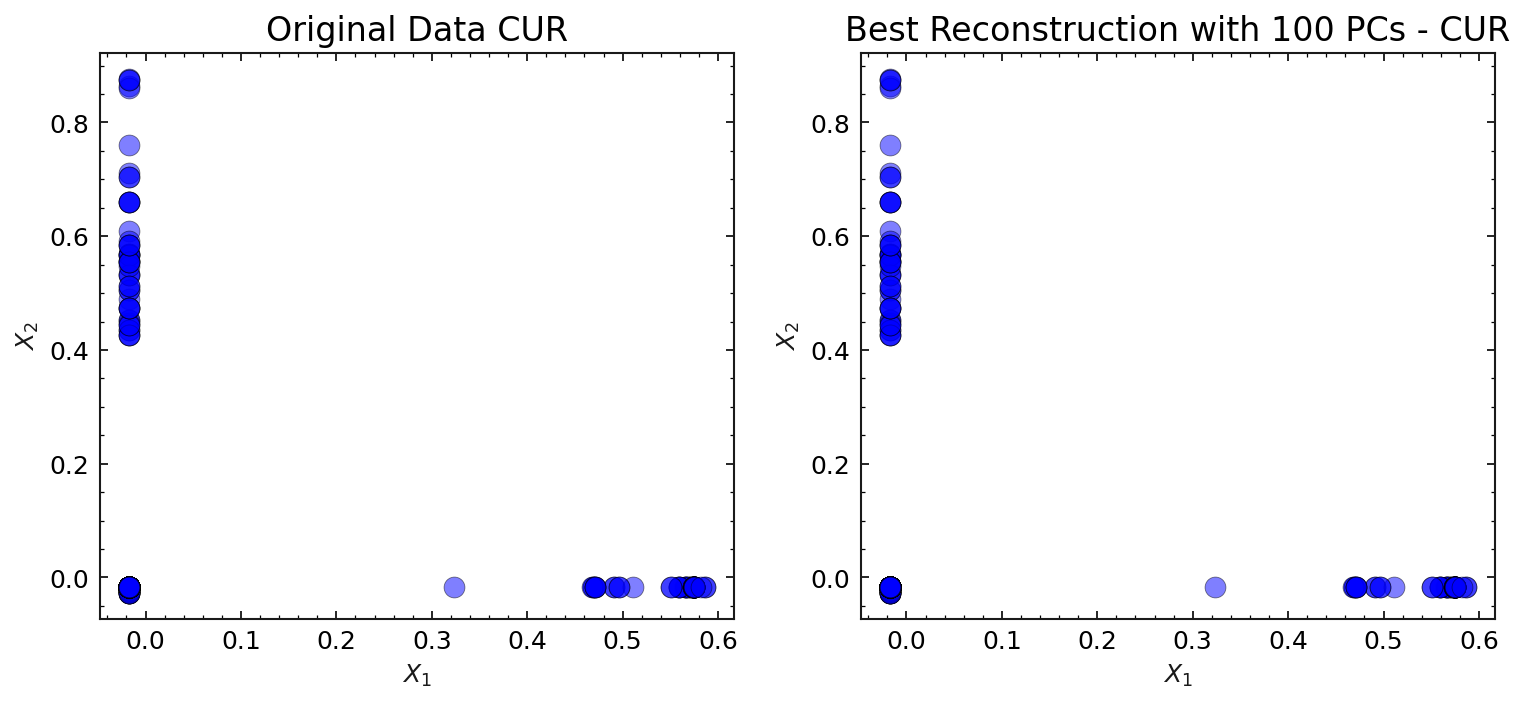

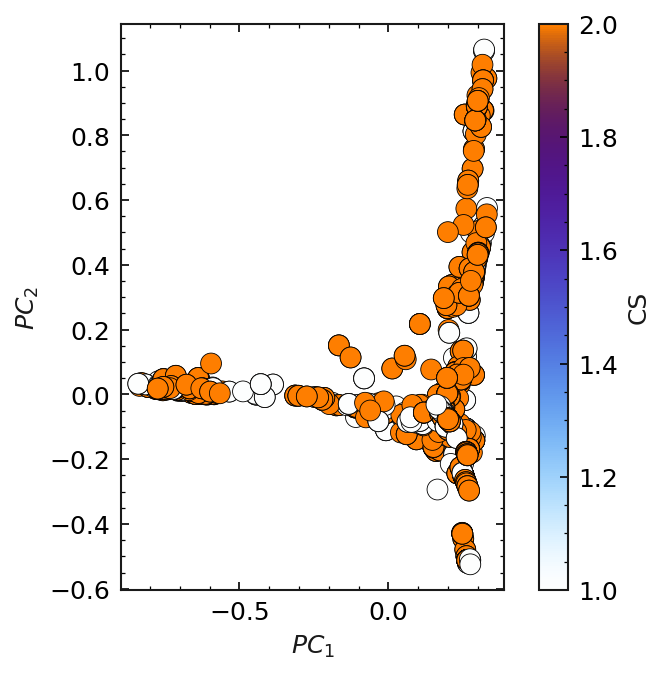

In [19]:
X_PCA1 = T1 @ PTX1
fig, ax = plt.subplots(1, 2, figsize=dbl_fig)
plot_simple(X1_train, fig=fig, ax=ax[0], title="Original Data FPS", **cmaps)
plot_simple(
    X_PCA1,
    fig=fig,
    ax=ax[1],
    title="Best Reconstruction with {} PCs - FPS".format(n_PC),
    **cmaps
)
T_PCA_test1 = X1_test @ PXT1
X_test_PCA1 = T_PCA_test1 @ PTX1
plot_projection(Y_test, T_PCA_test1, **cmaps)
plt.show()
plt.close()

X_PCA2 = T2 @ PTX2
fig, ax = plt.subplots(1, 2, figsize=dbl_fig)
plot_simple(X2_train, fig=fig, ax=ax[0], title="Original Data CUR", **cmaps)
plot_simple(
    X_PCA2,
    fig=fig,
    ax=ax[1],
    title="Best Reconstruction with {} PCs - CUR".format(n_PC),
    **cmaps
)
T_PCA_test2 = X2_test@ PXT2
X_test_PCA2 = T_PCA_test2 @ PTX2
plot_projection(Y_test, T_PCA_test2, **cmaps)

In [20]:
table_from_dict([get_stats(x=X1_train, y=Y_train, t=T1, xr=X_PCA1), 
                 get_stats(x=X1_test, y=Y_test, t=T_PCA_test1, xr=X_test_PCA1)], 
                 headers = ["Training", "Testing"], 
                 title="PCA with FPS")

table_from_dict([get_stats(x=X2_train, y=Y_train, t=T2, xr=X_PCA2), 
                 get_stats(x=X2_test, y=Y_test, t=T_PCA_test2, xr=X_test_PCA2)], 
                 headers = ["Training", "Testing"], 
                 title="PCA with CUR")

<center><b> PCA with FPS </b></center><br>                            <center><table><tr><th></th><th><center>Training</center></th><th><center>Testing</center></th></tr><td> Dataset Variance<br>$\sigma_X^2$ </td>                                                <td> 1 </td><td> 1.0002 </td></tr><tr><td> Projection Variance<br>$\sigma_T^2$ </td>                                                <td> 1 </td><td> 1.0002 </td></tr><tr><td> Residual Variance<br>$\sigma_X^2 - \sigma_T^2$ </td>                                                <td> -1.08802e-14 </td><td> 3.10862e-15 </td></tr><tr><td> $\ell_{proj}$ </td>                                                <td> 3.042e-30 </td><td> 3.0316e-30 </td></tr></table></center>

<center><b> PCA with CUR </b></center><br>                            <center><table><tr><th></th><th><center>Training</center></th><th><center>Testing</center></th></tr><td> Dataset Variance<br>$\sigma_X^2$ </td>                                                <td> 1 </td><td> 1.00064 </td></tr><tr><td> Projection Variance<br>$\sigma_T^2$ </td>                                                <td> 1 </td><td> 1.00064 </td></tr><tr><td> Residual Variance<br>$\sigma_X^2 - \sigma_T^2$ </td>                                                <td> -1.55431e-15 </td><td> -6.66134e-16 </td></tr><tr><td> $\ell_{proj}$ </td>                                                <td> 2.90977e-30 </td><td> 2.87659e-30 </td></tr></table></center>

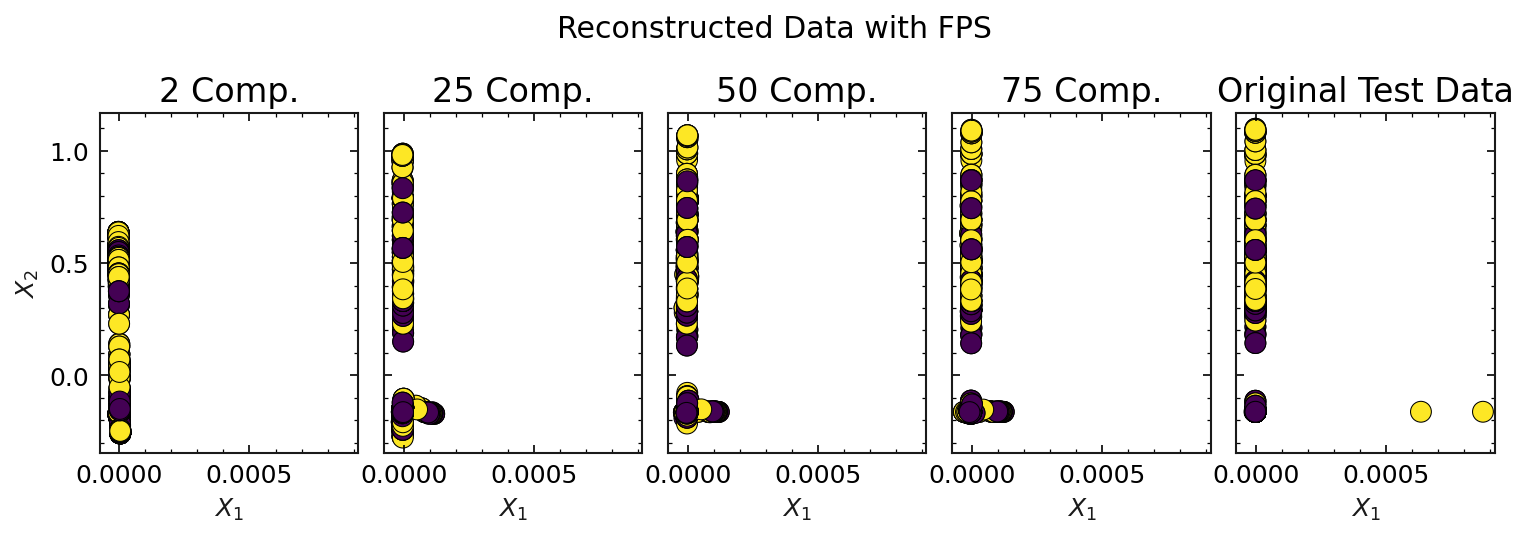

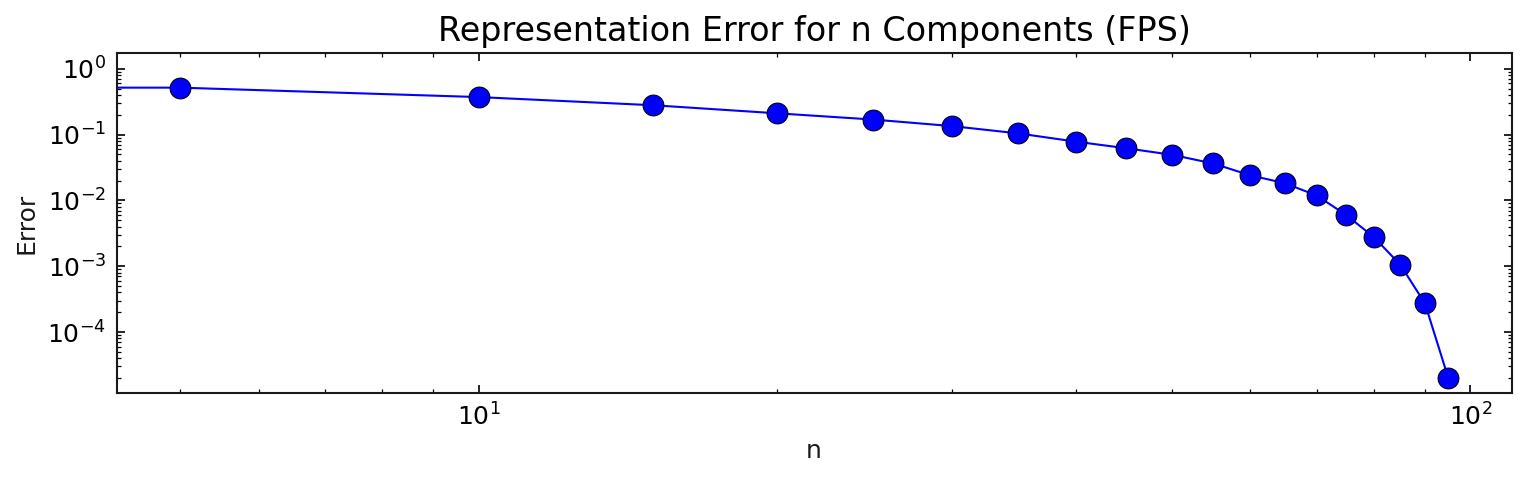

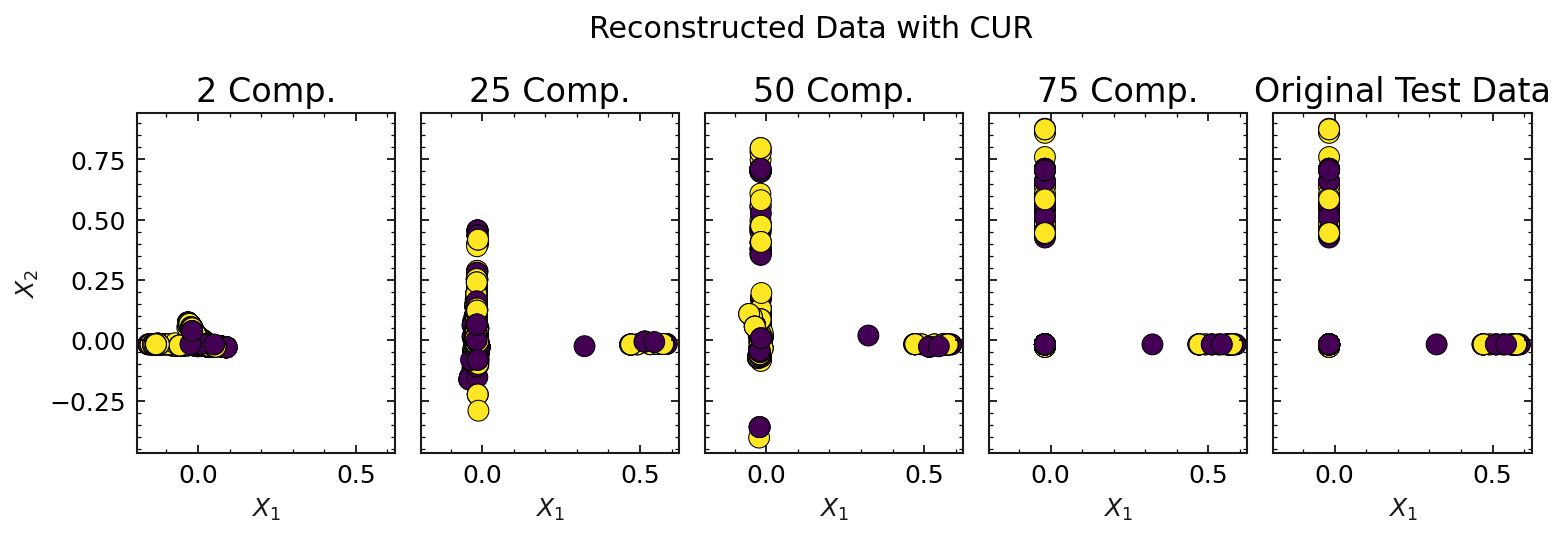

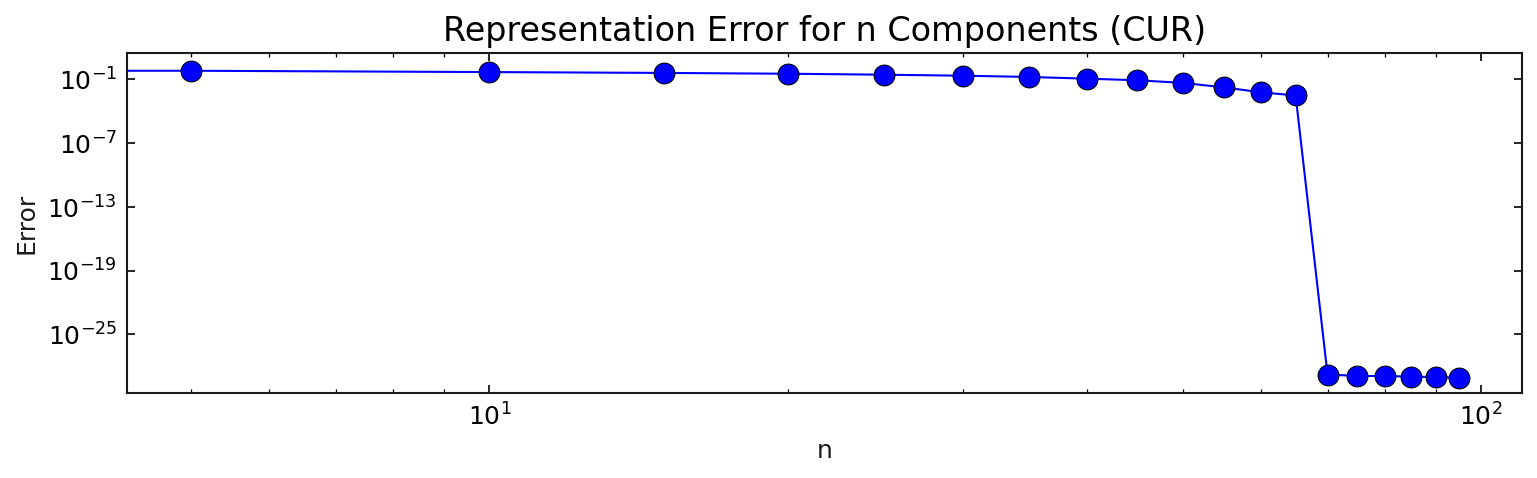

In [22]:
trials1 = range(X1_test.shape[1])[::5]
trials2 = range(X2_test.shape[1])[::5]

n_plot = 4
fsize = (3 * n_plot, 3)

fig, ax = plt.subplots(1, n_plot + 1, figsize=fsize, sharex=True, sharey=True)

for i, n in enumerate(trials1[:: int(len(trials1) / n_plot)]):
    n = max(n, 2)
    PXT1 = U_C1[:, :n]
    PTX1 = PXT1.T

    X1_r = X1_test @ PXT1 @ PTX1

    ax[i].scatter(X1_r[:, 0], X1_r[:, 1], c=Y_test[:, 0], linewidth=0.5, edgecolor="k")
    ax[i].set_title(f"{n} Comp.")
    ax[i].set_xlabel(r"$X_1$")

ax[-1].scatter(X1_test[:, 0], X1_test[:, 1], c=Y_test[:, 0], linewidth=0.5, edgecolor="k")
ax[-1].set_title("Original Test Data")
ax[-1].set_xlabel(r"$X_1$")
ax[0].set_ylabel(r"$X_2$")

fig.suptitle("Reconstructed Data with FPS", y=1.1)
fig.subplots_adjust(wspace=0.1)

plt.figure(figsize=fsize)
plt.loglog(
    trials1,
    [
        ((X1_test - X1_test @ U_C1[:, 0:n] @ U_C1[:, :n].T) ** 2).mean(axis=0).sum()
        for n in trials1
    ],
    "b-",
    marker="o",
)
plt.title(r"Representation Error for n Components (FPS)")
plt.xlabel("n")
plt.ylabel("Error")
plt.show()
plt.close()



n_plot = 4
fsize = (3 * n_plot, 3)

fig, ax = plt.subplots(1, n_plot + 1, figsize=fsize, sharex=True, sharey=True)

for i, n in enumerate(trials2[:: int(len(trials2) / n_plot)]):
    n = max(n, 2)
    PXT2 = U_C2[:, :n]
    PTX2 = PXT2.T

    X2_r = X2_test @ PXT2 @ PTX2

    ax[i].scatter(X2_r[:, 0], X2_r[:, 1], c=Y_test[:, 0], linewidth=0.5, edgecolor="k")
    ax[i].set_title(f"{n} Comp.")
    ax[i].set_xlabel(r"$X_1$")

ax[-1].scatter(X2_test[:, 0], X2_test[:, 1], c=Y_test[:, 0], linewidth=0.5, edgecolor="k")
ax[-1].set_title("Original Test Data")
ax[-1].set_xlabel(r"$X_1$")
ax[0].set_ylabel(r"$X_2$")

fig.suptitle("Reconstructed Data with CUR", y=1.1)
fig.subplots_adjust(wspace=0.1)

plt.figure(figsize=fsize)
plt.loglog(
    trials2,
    [
        ((X2_test - X2_test @ U_C2[:, 0:n] @ U_C2[:, :n].T) ** 2).mean(axis=0).sum()
        for n in trials2
    ],
    "b-",
    marker="o",
)
plt.title(r"Representation Error for n Components (CUR)")
plt.xlabel("n")
plt.ylabel("Error")
plt.show()
plt.close()

In [23]:
regularization = 1e-6
lr = Ridge(alpha=regularization)

lr.fit(X1_train, Y_train)
Yhat_train1 = lr.predict(X1_train).reshape((-1, Y_train.shape[1]))

lr.fit(X2_train, Y_train)
Yhat_train2 = lr.predict(X2_train).reshape((-1, Y_train.shape[1]))

In [24]:
alpha = 0.5

K_pca1 = X1_train @ X1_train.T
K_lr1 = Yhat_train1 @ Yhat_train1.T

K1= (alpha * K_pca1) + (1.0 - alpha) * K_lr1

K_pca2 = X2_train @ X2_train.T
K_lr2 = Yhat_train2 @ Yhat_train2.T

K2= (alpha * K_pca2) + (1.0 - alpha) * K_lr2


In [26]:
v_Kt1, U_Kt1 = np.linalg.eigh(K1)
v_Kt2, U_Kt2 = np.linalg.eigh(K2)

# U_Kt/v_Kt are already sorted, but in *increasing* order, so reverse them
U_Kt1 = np.flip(U_Kt1, axis=1)
v_Kt1 = np.flip(v_Kt1, axis=0)

U_Kt1 = U_Kt1[:,v_Kt1>0]
v_Kt1 = v_Kt1[v_Kt1>0]

U_Kt2 = np.flip(U_Kt2, axis=1)
v_Kt2 = np.flip(v_Kt2, axis=0)

U_Kt2 = U_Kt2[:,v_Kt2>0]
v_Kt2 = v_Kt2[v_Kt2>0]



In [27]:
T1 = U_Kt1[:, :n_PC] @ np.diagflat(np.sqrt(v_Kt1[:n_PC]))
T2 = U_Kt2[:, :n_PC] @ np.diagflat(np.sqrt(v_Kt2[:n_PC]))


In [28]:
P_lr1 = X1_train.T @ X1_train + np.eye(X1_train.shape[1]) * regularization
P_lr1 = np.linalg.pinv(P_lr1)
P_lr1 = (P_lr1 @ X1_train.T @ Y_train).reshape((-1, Y_train.shape[1])) @ Yhat_train1.T

P_pca1 = X1_train.T

P1 = (alpha * P_pca1) + (1.0 - alpha) * P_lr1
PXT1 = P1@ U_Kt1[:, :n_PC] @ np.diag(1 / np.sqrt(v_Kt1[:n_PC]))




P_lr2 = X2_train.T @ X2_train + np.eye(X2_train.shape[1]) * regularization
P_lr2 = np.linalg.pinv(P_lr2)
P_lr2 = (P_lr2 @ X2_train.T @ Y_train).reshape((-1, Y_train.shape[1])) @ Yhat_train2.T

P_pca2 = X2_train.T

P2 = (alpha * P_pca2) + (1.0 - alpha) * P_lr2
PXT2 = P1@ U_Kt2[:, :n_PC] @ np.diag(1 / np.sqrt(v_Kt2[:n_PC]))

In [29]:


print(np.linalg.norm(X1_train @ PXT1 - T1))
print(np.linalg.norm(X2_train @ PXT2 - T2))



51.3481378848
7148881591.44


In [32]:


T_pcovr_test1 = X1_test @ PXT1
T_pcovr_test2 = X2_test @ PXT2



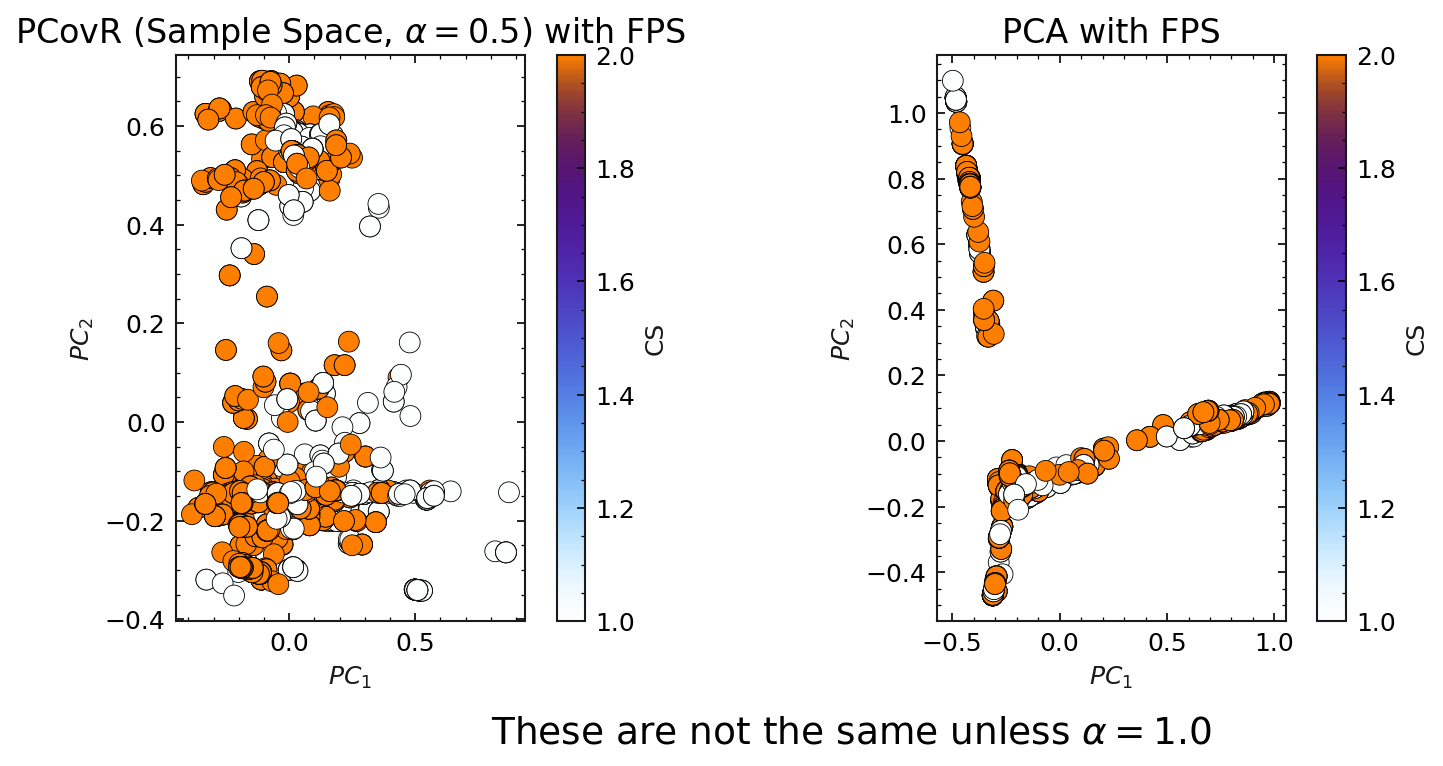

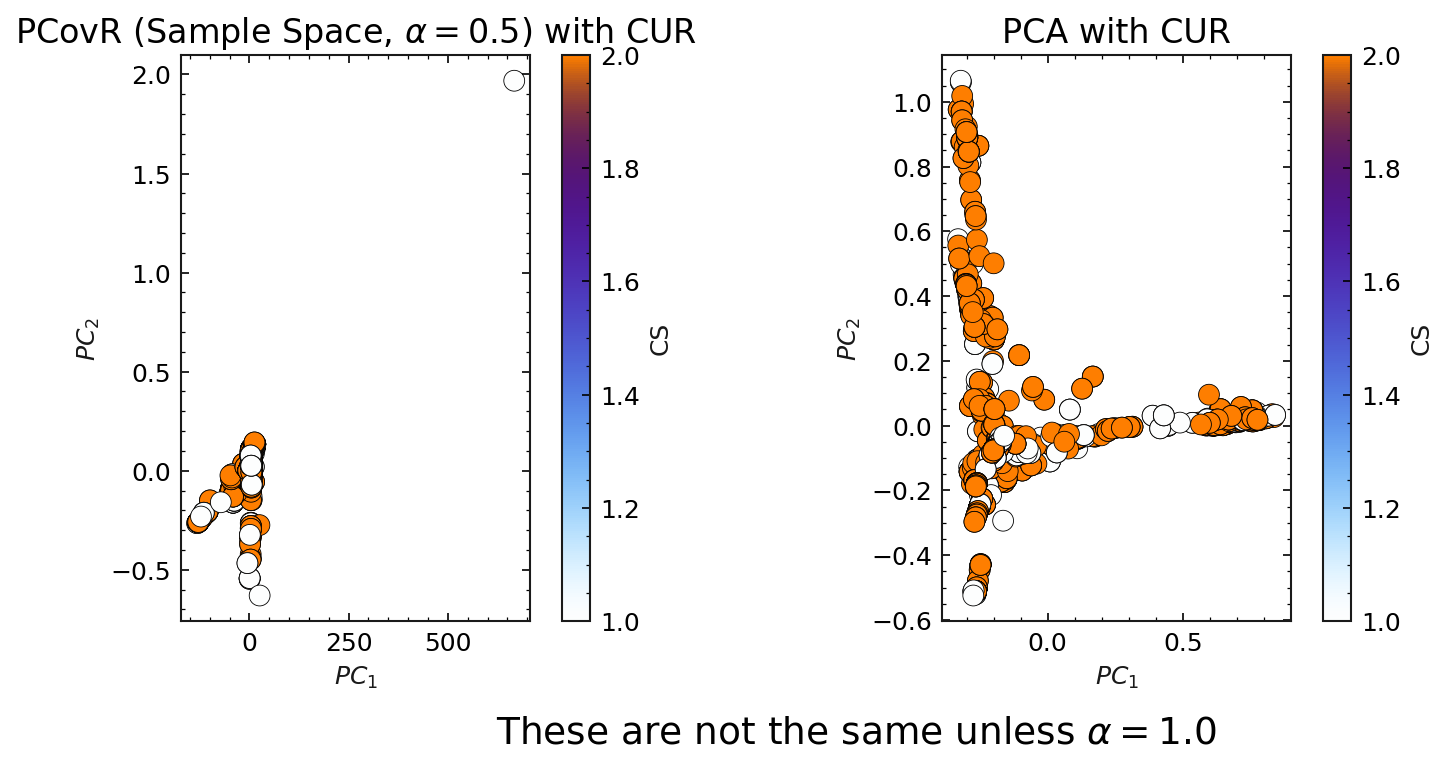

In [34]:
fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

ref1 = PCA(n_components=n_PC)
ref1.fit(X1_train)
t_ref1 = ref1.transform(X1_test)

plot_projection(
    Y_test,
    check_mirrors(T_pcovr_test1, t_ref1),
    fig=fig,
    ax=axes[0],
    title=r"PCovR (Sample Space, $\alpha={}$) with FPS".format(alpha),
    **cmaps
)
plot_projection(Y_test, t_ref1, fig=fig, ax=axes[1], title="PCA with FPS", **cmaps)

fig.suptitle(
    r"These are not the same unless $\alpha = 1.0.$",
    y=0.0,
    fontsize=plt.rcParams["font.size"] + 6,
)
plt.show()
plt.close()



fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

ref2 = PCA(n_components=n_PC)
ref2.fit(X2_train)
t_ref2 = ref2.transform(X2_test)

plot_projection(
    Y_test,
    check_mirrors(T_pcovr_test2, t_ref2),
    fig=fig,
    ax=axes[0],
    title=r"PCovR (Sample Space, $\alpha={}$) with CUR".format(alpha),
    **cmaps
)
plot_projection(Y_test, t_ref2, fig=fig, ax=axes[1], title="PCA with CUR", **cmaps)

fig.suptitle(
    r"These are not the same unless $\alpha = 1.0.$",
    y=0.0,
    fontsize=plt.rcParams["font.size"] + 6,
)
plt.show()
plt.close()

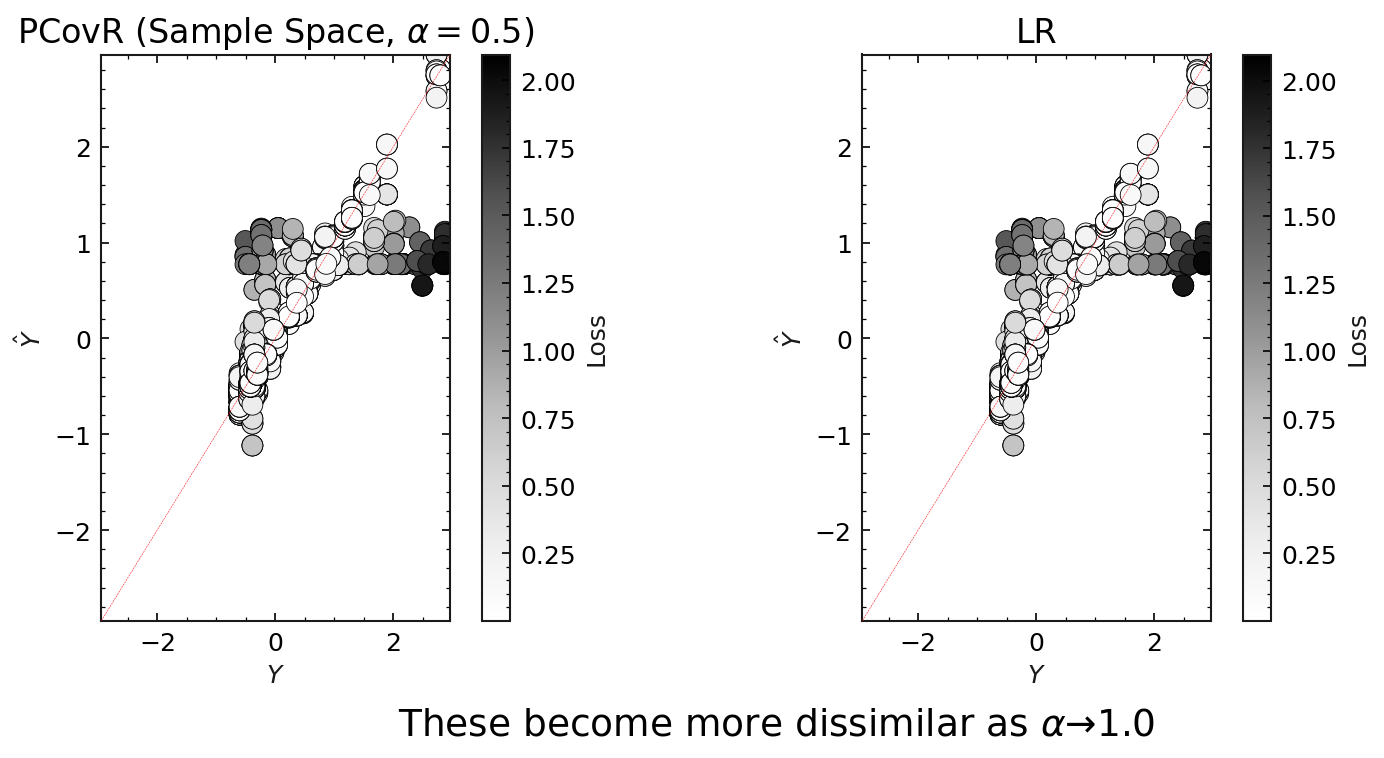

In [41]:
PTY = np.diagflat(1 / (v_Kt[:n_PC])) @ T.T @ Y_train
Y_pcovr_test = X_test @ PXT @ PTY

fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

ref_lr = Ridge(alpha=regularization)
ref_lr.fit(X_train, Y_train)
yref = lr.predict(X_test)

plot_regression(
    Y_test[:, 0],
    Y_pcovr_test[:, 0],
    fig=fig,
    ax=axes[0],
    title=r"PCovR (Sample Space, $\alpha={}$)".format(alpha),
    **cmaps
)
plot_regression(Y_test[:, 0], yref[:, 0], fig=fig, ax=axes[1], title="LR", **cmaps)

fig.suptitle(
    r"These become more dissimilar as $\alpha \to 1.0.$",
    y=0.01,
    fontsize=plt.rcParams["font.size"] + 6,
)
plt.show()


In [42]:
C = X_train.T @ X_train

PXV = PXT @ np.diagflat(1.0/np.sqrt(v_Kt[:n_PC]))

print(np.linalg.norm(PXV.T @ C @ PXV - 
                     np.eye(PXV.shape[1])))

4.7378604491347074e-08


In [43]:
v_C, U_C = np.linalg.eigh(C)

# U_C/v_C are already sorted, but in *increasing* order, so reverse them
U_C = np.flip(U_C, axis=1)
v_C = np.flip(v_C, axis=0)

U_C = U_C[:,v_C>0]
v_C = v_C[v_C>0]

Csqrt = U_C @ np.diagflat(np.sqrt(v_C)) @ U_C.T
iCsqrt = U_C @ np.diagflat(1.0 / np.sqrt(v_C)) @ U_C.T

In [44]:
Ct = iCsqrt @ X_train.T
Ct = Ct @ K @ Ct.T

v_Ct, U_Ct = np.linalg.eigh(Ct)
U_Ct = np.flip(U_Ct, axis=1)
v_Ct = np.flip(v_Ct, axis=0)

U_Ct = U_Ct[:,v_Ct>0]
v_Ct = v_Ct[v_Ct>0]

In [46]:
PXV = iCsqrt @ U_Ct[:, :n_PC]

In [47]:
PXT = PXV @ np.diagflat(np.sqrt(v_Ct[:n_PC]))
PTX = np.diagflat(1.0 / np.sqrt(v_Ct[:n_PC])) @ U_Ct[:, :n_PC].T, Csqrt
PTY = (
    np.diagflat(1.0 / np.sqrt(v_Ct[:n_PC]))
    @ U_Ct[:, :n_PC].T
    @ iCsqrt
    @ X_train.T
    @ Y_train
)

In [49]:
T_fspcovr_test = X_test @ PXT

Y_fspcovr_test = T_fspcovr_test @ PTY

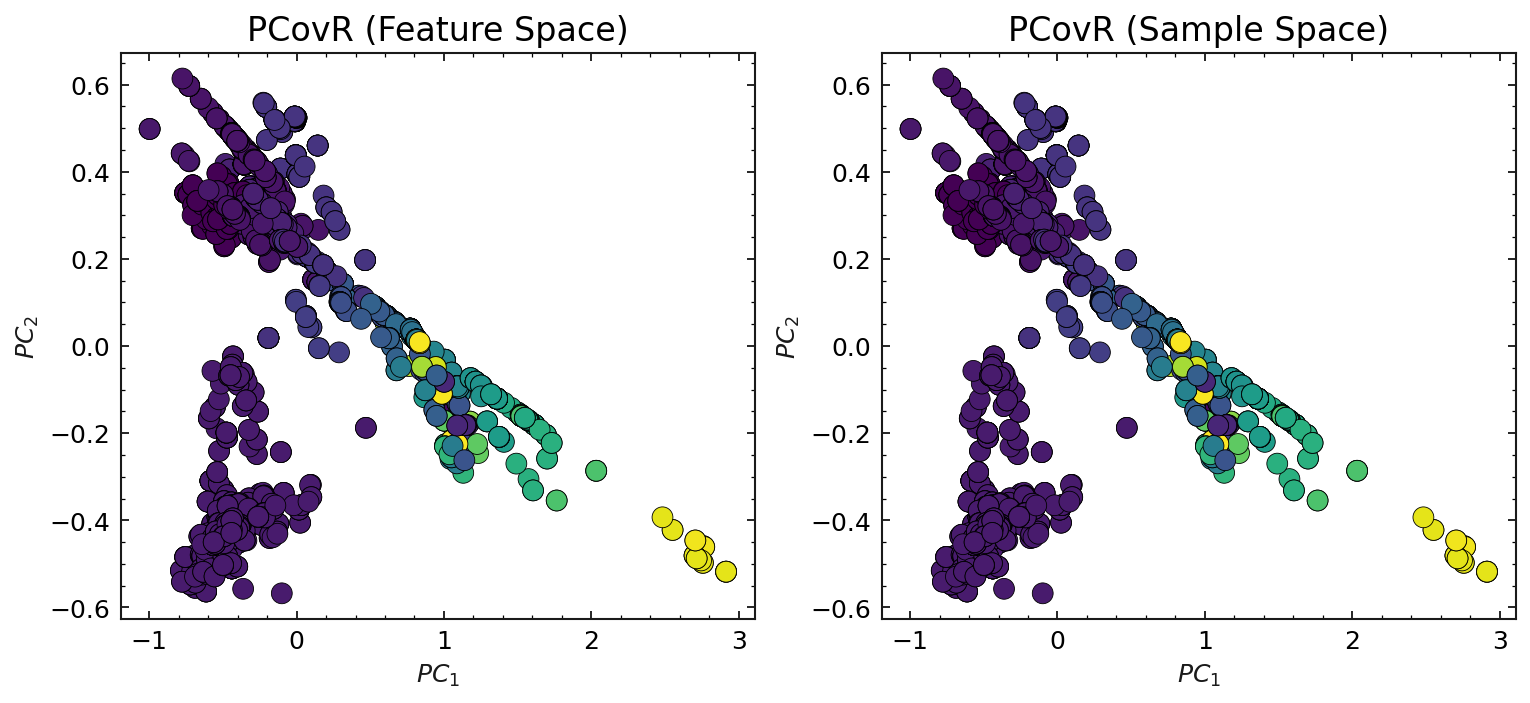

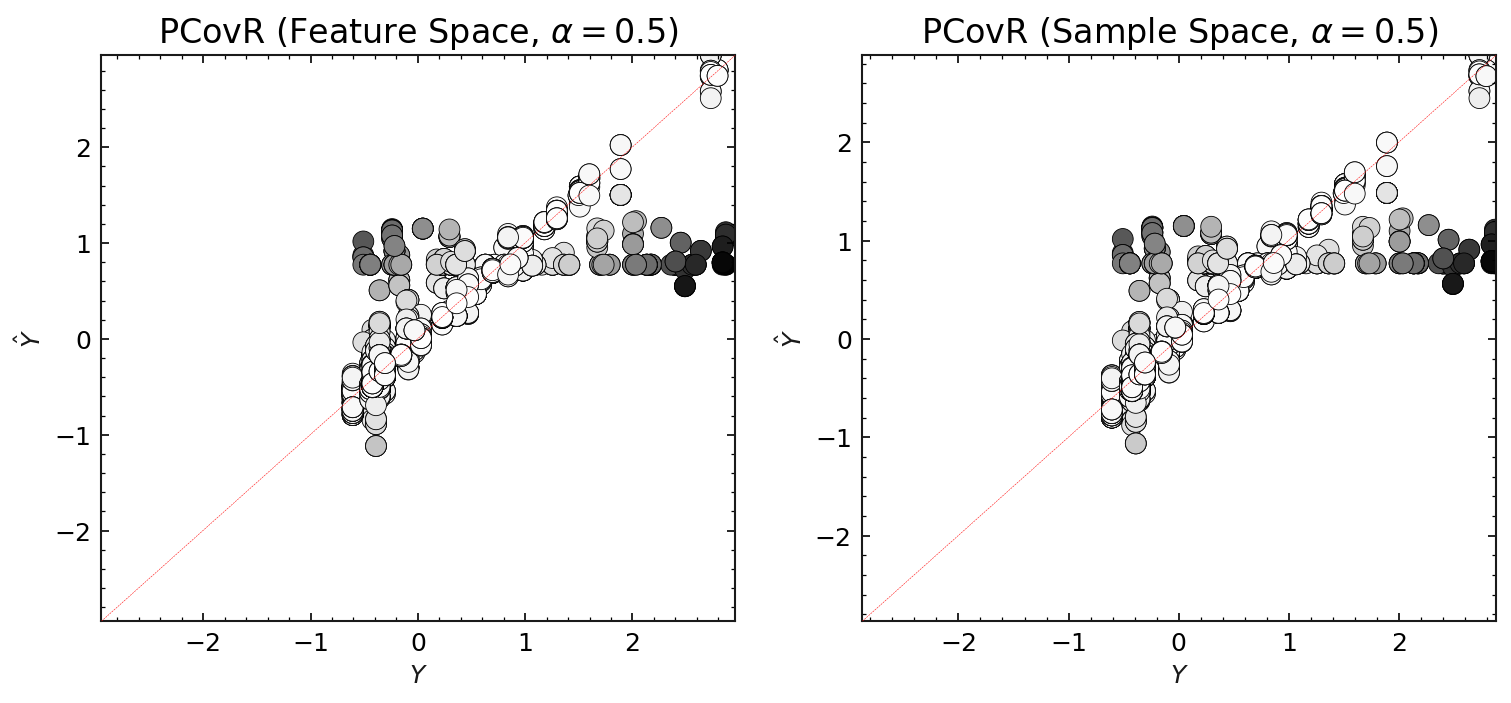

In [50]:
fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

ref = PCovR(mixing=alpha, n_components=2, space="sample")
ref.fit(X_train, Y_train)
tref = ref.transform(X_test)
yref = ref.predict(X_test)
xref = ref.inverse_transform(tref)

plot_projection(
    Y_test,
    check_mirrors(T_fspcovr_test, tref),
    fig=fig,
    ax=axes[0],
    title="PCovR (Feature Space)",
    **cmaps
)
plot_projection(
    Y_test, tref, fig=fig, ax=axes[1], title="PCovR (Sample Space)", **cmaps
)

fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

plot_regression(
    Y_test[:, 0],
    Y_fspcovr_test[:, 0],
    fig=fig,
    ax=axes[0],
    title=r"PCovR (Feature Space, $\alpha={}$)".format(alpha),
    cbar=False,
    **cmaps
)
plot_regression(
    Y_test[:, 0],
    yref[:, 0],
    fig=fig,
    ax=axes[1],
    title=r"PCovR (Sample Space, $\alpha={}$)".format(alpha),
    cbar=False,
    **cmaps
)

plt.show()

In [52]:


n_alphas = 11
alphas = np.linspace(0.0, 1.0, n_alphas)
components = np.arange(0, 5, 1, dtype=int)[2::]
n_components = components.size

pcovr_calculators = np.array(
    [
        [PCovR(mixing=a, n_components=c, space="feature") for a in alphas]
        for c in components
    ]
)

for cdx, c in enumerate(components):
    for adx, a in enumerate(alphas):
        pcovr_calculators[cdx][adx].fit(X_train, Y_train)



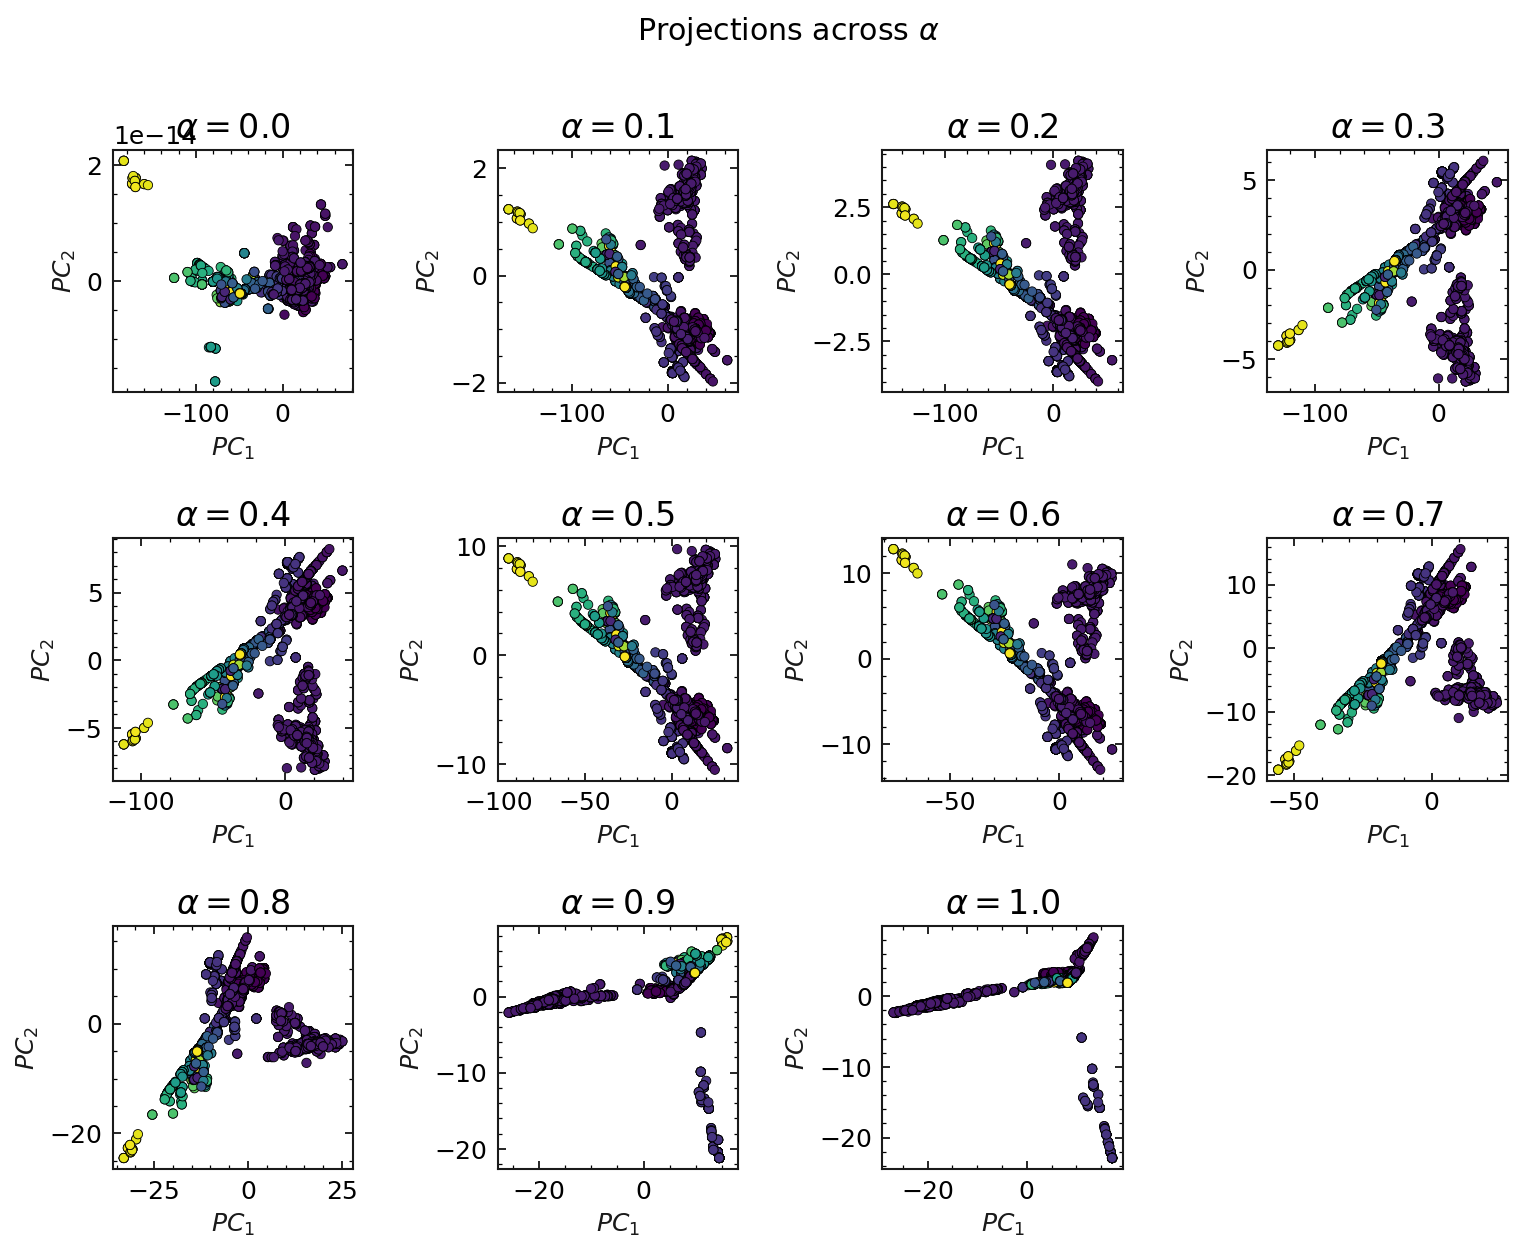

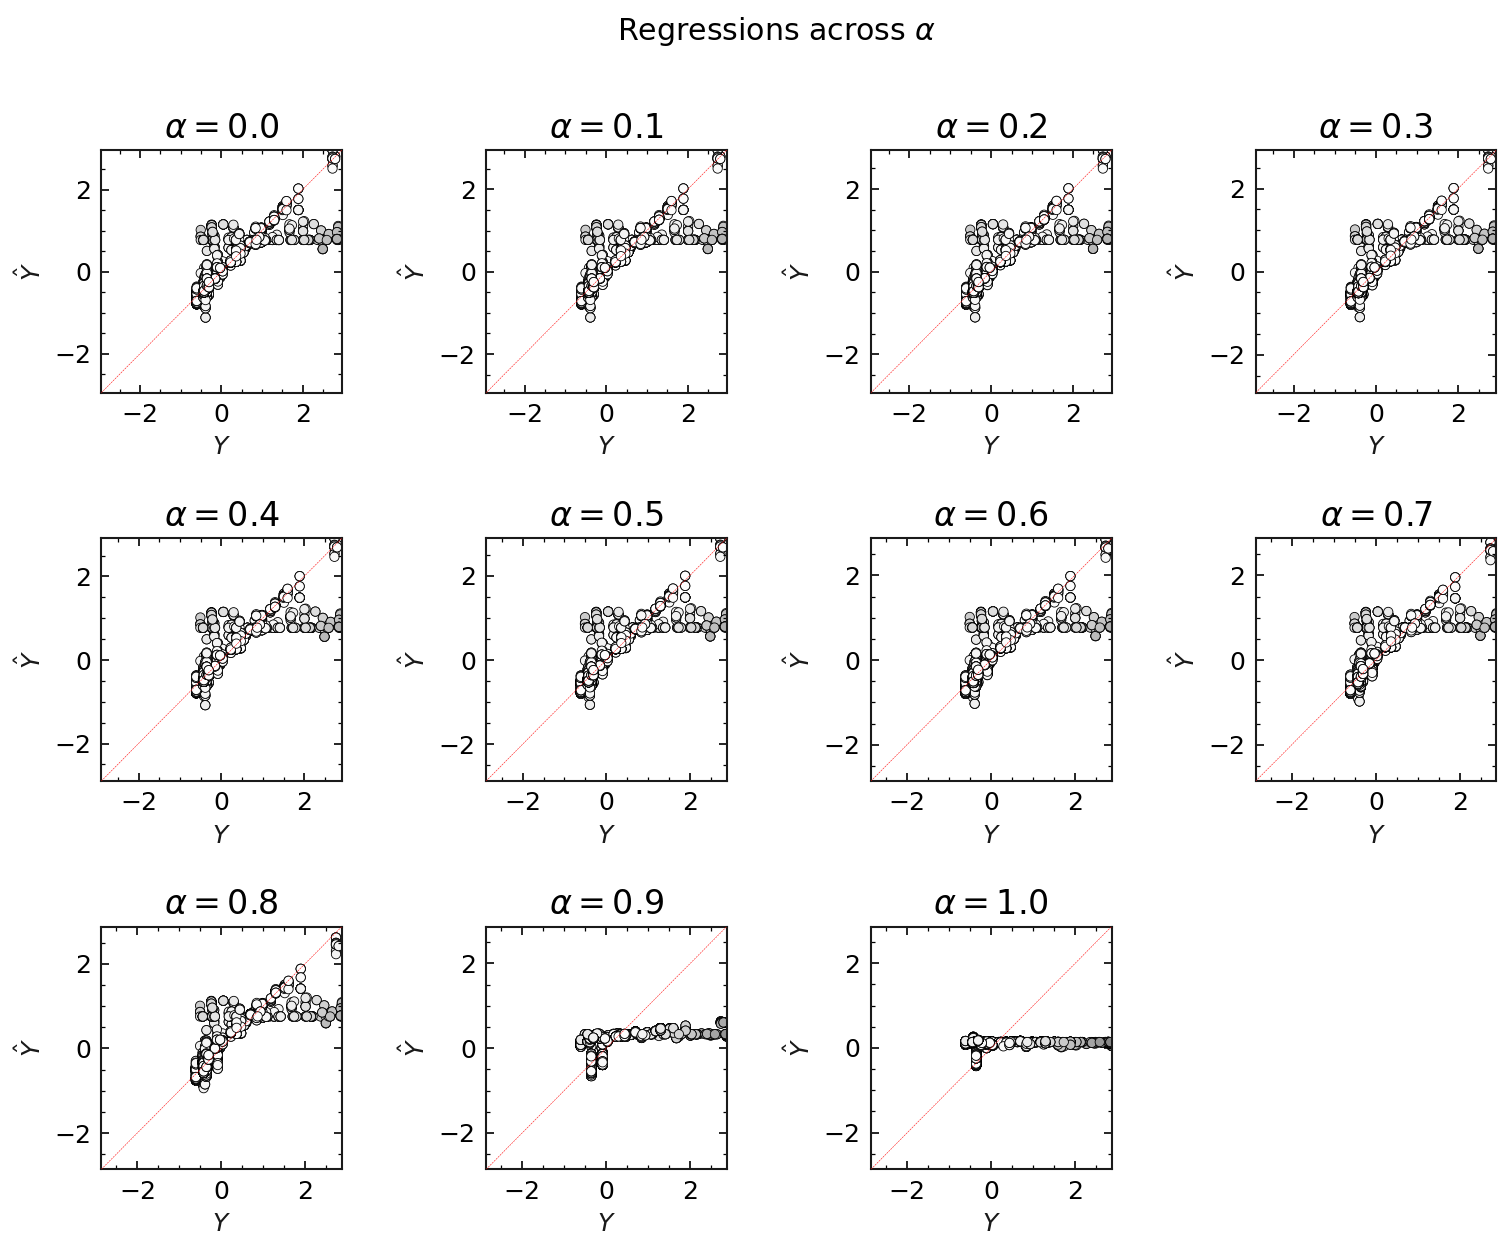

In [53]:
n_plots = int(n_alphas ** 0.5)
scale = 3

t_ref = pcovr_calculators[0][-3].transform(X_test)
y_ref = pcovr_calculators[0][-3].predict(X_test)
x_ref = pcovr_calculators[0][-3].inverse_transform(tref)

pfig, pax = plt.subplots(
    n_plots,
    int(np.ceil(n_alphas / n_plots)),
    figsize=(
        scale * int(np.ceil(n_alphas / n_plots)),
        scale * n_plots,
    ),
)

rfig, rax = plt.subplots(
    n_plots,
    int(np.ceil(n_alphas / n_plots)),
    figsize=(
        scale * int(np.ceil(n_alphas / n_plots)),
        scale * n_plots,
    ),
)
for p, r, pcovr in zip(pax.flatten(), rax.flatten(), pcovr_calculators[0]):

    t = pcovr.transform(X_test)
    y = pcovr.predict(X_test)
    x = pcovr.inverse_transform(t)

    plot_projection(
        Y_test, check_mirrors(t, t_ref), fig=pfig, ax=p, alpha=1.0, s=20, **cmaps
    )

    plot_regression(
        Y_test[:, 0],
        y[:, 0],
        fig=pfig,
        ax=r,
        cbar=False,
        vmin=0,
        vmax=5,
        alpha=1.0,
        s=20,
        **cmaps,
    )

    p.set_title(r"$\alpha=$" + str(round(pcovr.mixing, 3)))
    r.set_title(r"$\alpha=$" + str(round(pcovr.mixing, 3)))


for p, r in zip(pax.flatten()[n_alphas:], rax.flatten()[n_alphas:]):
    p.axis("off")
    r.axis("off")

pfig.subplots_adjust(wspace=0.6, hspace=0.6)
pfig.suptitle(r"Projections across $\alpha$")
rfig.subplots_adjust(wspace=0.6, hspace=0.6)
rfig.suptitle(r"Regressions across $\alpha$")

plt.show()


In [54]:
L_pca = np.zeros((n_components, n_alphas))
L_lr = np.zeros((n_components, n_alphas))

for cdx, c in enumerate(components):
    for adx, a in enumerate(alphas):
        calculator = pcovr_calculators[cdx][adx]
        
        # TODO: remove except when score is merged into skcosmo
        try:
            L_pca[cdx, adx], L_lr[cdx, adx] = calculator.score(X_test, Y_test)
        except:
            xr = calculator.inverse_transform(calculator.transform(X_test))
            yp = calculator.predict(X_test)

            L_pca[cdx, adx] = (
                np.linalg.norm(X_test - xr) ** 2.0 / np.linalg.norm(X_test) ** 2.0
            )
            L_lr[cdx, adx] = (
                np.linalg.norm(Y_test - yp) ** 2.0 / np.linalg.norm(Y_test) ** 2.0
            )

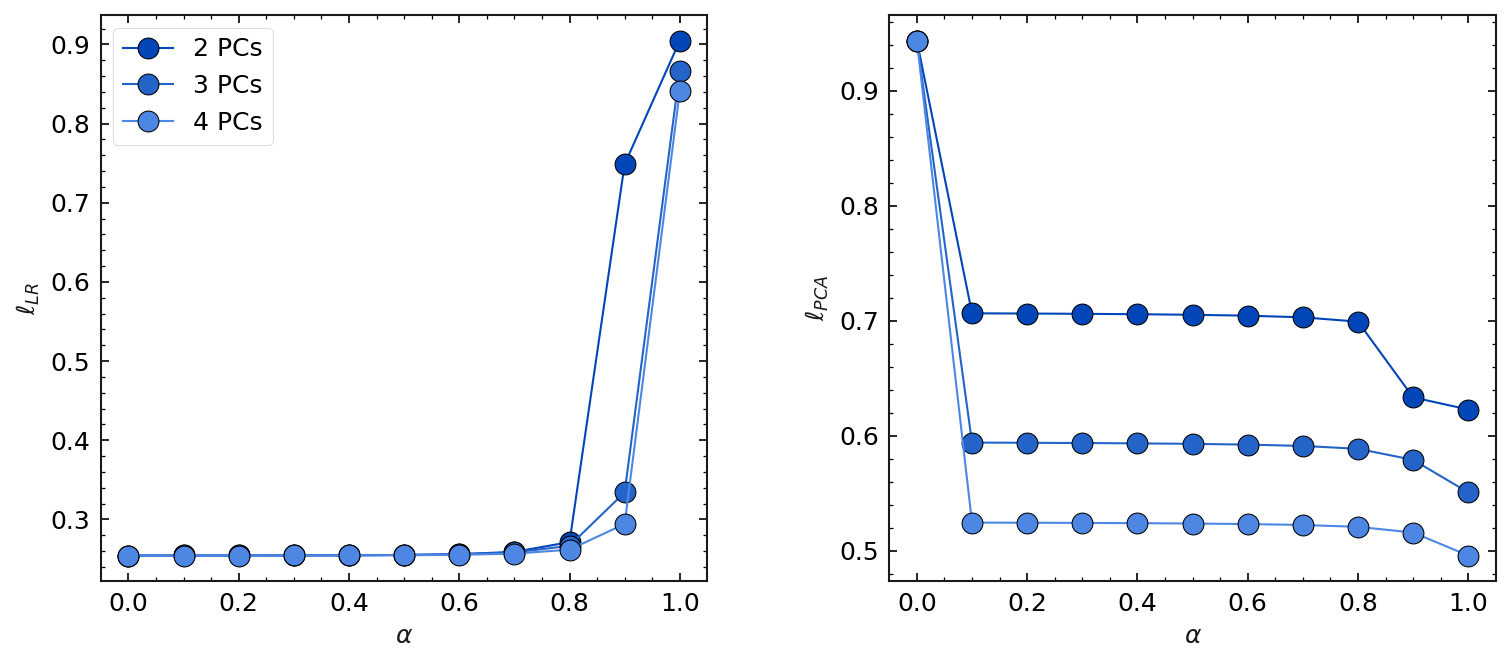

In [55]:
fig, [axsLR, axsPCA] = plt.subplots(1, 2, figsize=dbl_fig, sharex=True)

for cdx, c in enumerate(components):
    axsLR.plot(alphas, L_lr[cdx, :], marker="o", label="{:d} PCs".format(c))
    axsPCA.plot(alphas, L_pca[cdx, :], marker="o", label="{:d} PCs".format(c))

axsLR.set_ylabel(r"$\ell_{LR}$")
axsLR.set_xlabel(r"$\alpha$")
axsPCA.set_ylabel(r"$\ell_{PCA}$")
axsPCA.set_xlabel(r"$\alpha$")

fig.subplots_adjust(wspace=0.3)
axsLR.legend()
plt.show()

Optimal alpha for 2 PCs = 0.50
Optimal alpha for 3 PCs = 0.50
Optimal alpha for 4 PCs = 0.50


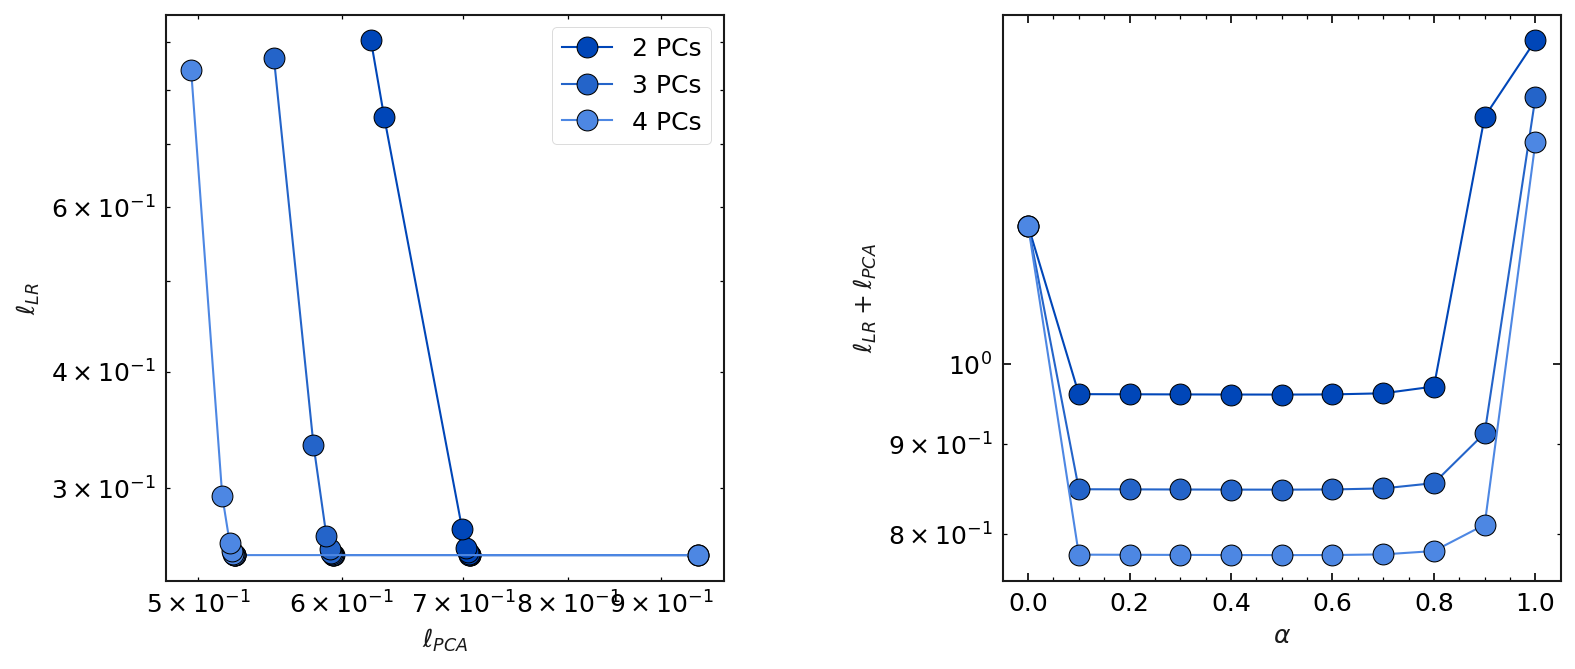

In [56]:
fig = plt.figure(figsize=dbl_fig)
axsLoss = fig.add_subplot(1, 2, 1)
axsSum = fig.add_subplot(1, 2, 2)

for cdx, c in enumerate(components):
    axsLoss.loglog(L_pca[cdx, :], L_lr[cdx, :], marker="o", label="{:d} PCs".format(c))

axsLoss.set_xlabel(r"$\ell_{PCA}$")
axsLoss.set_ylabel(r"$\ell_{LR}$")
axsLoss.legend()

for cdx, c in enumerate(components):
    loss_sum = L_lr[cdx, :] + L_pca[cdx, :]
    axsSum.semilogy(alphas, loss_sum, marker="o", label="{:d} PCs".format(c))
    print("Optimal alpha for {:d} PCs = {:.2f}".format(c, alphas[np.argmin(loss_sum)]))

axsSum.set_xlabel(r"$\alpha$")
axsSum.set_ylabel(r"$\ell_{LR} + \ell_{PCA}$")

fig.subplots_adjust(wspace=0.5, hspace=0.3)

plt.show()

In [32]:
"""Initializing StandarScaler and fitting the X_raw SOAP 2D matrix so that the standard 
normal distribution of the features has a mean of zero and a standard deviation of one """

scaler=StandardScaler()
scaler.fit(C) 
X_scaled=scaler.transform(C)
n_components = 2

# """Normal PCA, takes more memory"""

# pca=PCA(n_components=n_components) 
# pca.fit(X_scaled)
# X_pca = pca.fit_transform(X_scaled)

"""Incremental PCA, change batch size freely"""

ipca = IncrementalPCA(n_components=n_components, batch_size=20)
# ipca.fit(X_scaled)
X_ipca = ipca.fit_transform(X_scaled)

In [23]:
# natoms=(list(natoms(qb_red)))
def magic(l):
    cdict={}
    for i in range(len(l)): 
        if l[i]%4==0:
            c='r'
        else:
            c='b'
        cdict['natoms='+str(l[i])]=c
    return cdict


cdict={magic}
properties = {
    "PC1": {
        "target": "atom",
        "values": X_ipca[:,0],
    },
    "PC2": {
        "target": "atom",
        "values": X_ipca[:,1],
    },
    "atomic_species": {
        "target": "atom",
        "values": np.concatenate([frame.numbers for frame in frames_ase])
    },
}

write_input("chem_mixed.json.gz", frames=frames_ase)

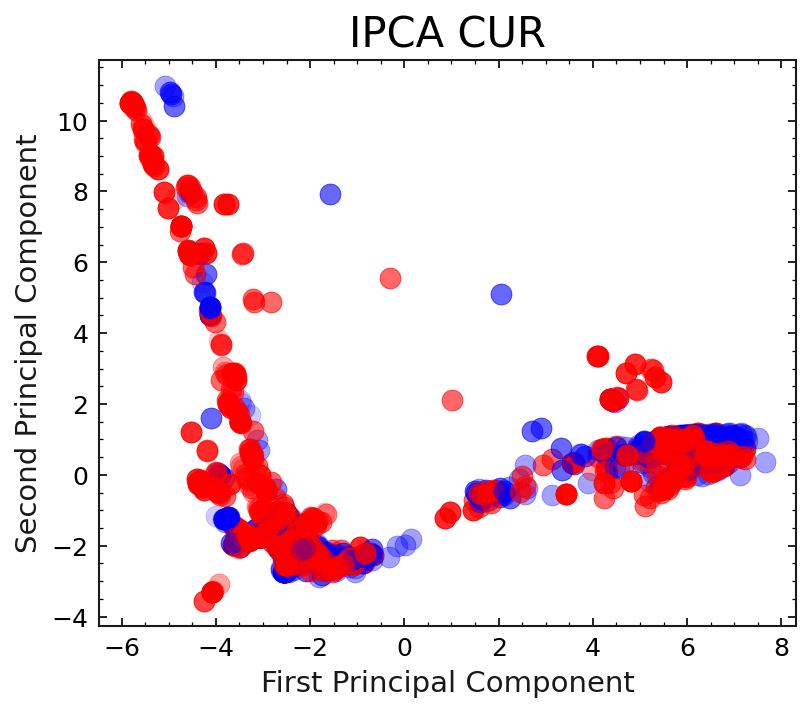

In [54]:
fig,ax=plt.subplots(figsize=(6,5))
start=0
for frame in frames_ase:
    natoms=(len(frame))
#     print(start, natoms)
    if natoms%4==0:
        ax.scatter(X_ipca[start:int(start+natoms), 0], X_ipca[start:int(start+natoms), 1],c='r', alpha=0.2)
    else:
        ax.scatter(X_ipca[start:int(start+natoms) , 0], X_ipca[start:int(start+natoms), 1], c='b', alpha=0.2)
    start=start+natoms
        # plt.savefig('PCA_2.png', bbox_inches= 'tight', dpi=400 )

plt.title("IPCA CUR",fontsize=20)
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.savefig('IPCA_mixed_db', bbox_inches= 'tight', dpi=700 )
plt.show()
plt.close()